## LIGHTBGM

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import lightgbm as lgb
from sklearn2pmml import sklearn2pmml
from sklearn2pmml.pipeline import PMMLPipeline
import pickle
import os
from datetime import timedelta

#### Load and preprocess data

In [2]:
df = pd.read_csv("TransformedData.csv")
df['Posted Time'] = pd.to_datetime(df['Posted Time'], format="%d/%m/%Y")
df.head()

,Posted Time,Longitude,Latitude,Area,Width,Length,Floors,Rooms,Toilets,Price per m2,...,House Direction_SOUTHWEST,House Direction_WEST,Furnishing Sell_BASIC_FINISHING,Furnishing Sell_FULLY_FURNISHED,Furnishing Sell_HIGH_END_FURNITURE,Furnishing Sell_RAW_HANDOVER,Land Type_AGRICULTURAL_LAND,Land Type_INDUSTRIAL_LAND,Land Type_PROJECT_LAND,Land Type_RESIDENTIAL_LAND
0,2025-01-31,10.400602,4.003590,10.000000,2.236068,4.472136,0.0,0.0,0.0,1.581139,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,2025-02-01,10.398891,4.009621,10.000000,2.236068,4.472136,0.0,0.0,0.0,1.581139,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,2025-01-13,10.399521,4.008289,8.660254,2.236068,3.872983,0.0,0.0,0.0,1.932184,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,2025-02-07,10.400602,3.996527,12.369317,2.236068,5.477226,0.0,0.0,0.0,1.646942,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,2025-02-02,10.397751,4.005646,10.000000,2.236068,4.472136,0.0,0.0,0.0,2.236068,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [3]:
df['year'] = df['Posted Time'].dt.year
df['month'] = df['Posted Time'].dt.month
df['day'] = df['Posted Time'].dt.day
df['dayofweek'] = df['Posted Time'].dt.dayofweek
df['quarter'] = df['Posted Time'].dt.quarter


# Drop the datetime column after extracting features
df.drop(columns=['Posted Time'], inplace=True)

print("Feature engineering complete.")
print(df.info())

Feature engineering complete.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23308 entries, 0 to 23307
Data columns (total 38 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Longitude                           23308 non-null  float64
 1   Latitude                            23308 non-null  float64
 2   Area                                23308 non-null  float64
 3   Width                               23308 non-null  float64
 4   Length                              23308 non-null  float64
 5   Floors                              23308 non-null  float64
 6   Rooms                               23308 non-null  float64
 7   Toilets                             23308 non-null  float64
 8   Price per m2                        23308 non-null  float64
 9   1 Part Residential                  23308 non-null  int64  
 10  All Residential                     23308 non-null  int64  
 11  Back Expans

#### Correlation analysis

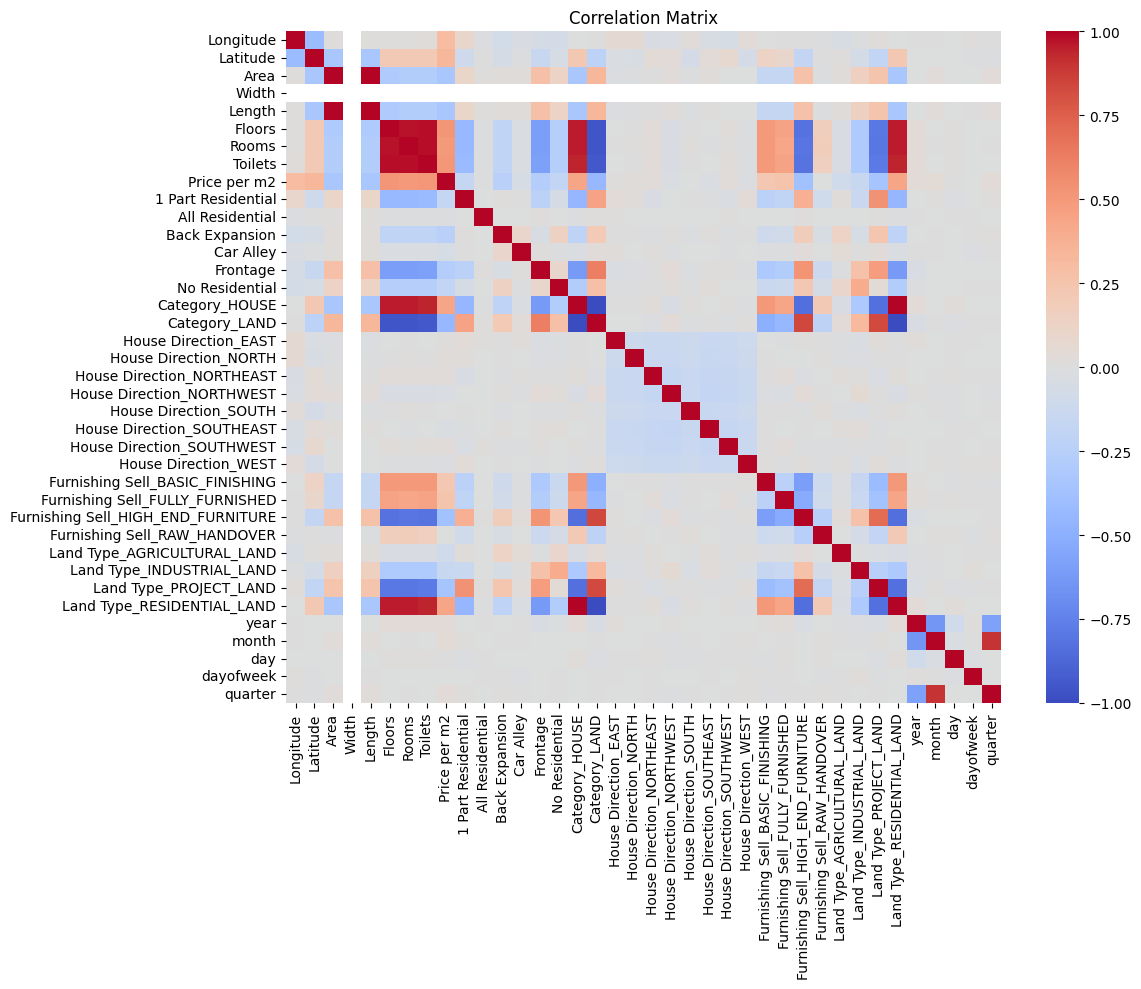

In [4]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), cmap='coolwarm', cbar=True)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()
plt.close()

In [5]:
corr_with_price = df.corr()['Price per m2'].abs().sort_values(ascending=False).drop('Price per m2')
print("Top 10 features correlated with Price per m2:\n", corr_with_price.head(10))

Top 10 features correlated with Price per m2:
 Floors                                0.516581
Toilets                               0.515551
Rooms                                 0.493683
Category_LAND                         0.442226
Category_HOUSE                        0.442226
Land Type_RESIDENTIAL_LAND            0.442226
Furnishing Sell_HIGH_END_FURNITURE    0.379951
Land Type_PROJECT_LAND                0.358016
Latitude                              0.342196
Area                                  0.333454
Name: Price per m2, dtype: float64


In [6]:
y = df['Price per m2']
X = df.drop('Price per m2', axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
# train = pd.read_csv("train.csv")
# test = pd.read_csv("test.csv")

# X_train = train.drop('Price per m2', axis=1)
# y_train = train['Price per m2']
# X_test = test.drop('Price per m2', axis=1)
# y_test = test['Price per m2']

# print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")

X_train: (18646, 37), X_test: (4662, 37)


#### Basic LightGBM model

In [7]:
print("\nTraining basic LightGBM model...")
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'rmse'},
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

basic_model = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=[lgb_train, lgb_eval],
    callbacks=[lgb.early_stopping(10)]
)


Training basic LightGBM model...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 0.742184	training's l2: 0.550838	valid_1's rmse: 0.834569	valid_1's l2: 0.696505


#### Evaluate basic model

In [8]:
y_train_pred = basic_model.predict(X_train)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

# Evaluate on Test Set
y_test_pred = basic_model.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print("=== Basic LightGBM Evaluation ===")
print(f"Training MSE: {mse_train:.5f}, RMSE: {rmse_train:.5f}, MAE: {mae_train:.5f}, R2: {r2_train:.5f}")
print(f"Test MSE: {mse_test:.5f}, RMSE: {rmse_test:.5f}, MAE: {mae_test:.5f}, R2: {r2_test:.5f}")

=== Basic LightGBM Evaluation ===
Training MSE: 0.55084, RMSE: 0.74218, MAE: 0.52010, R2: 0.83797
Test MSE: 0.69651, RMSE: 0.83457, MAE: 0.57209, R2: 0.79914


#### Plot actual vs predicted

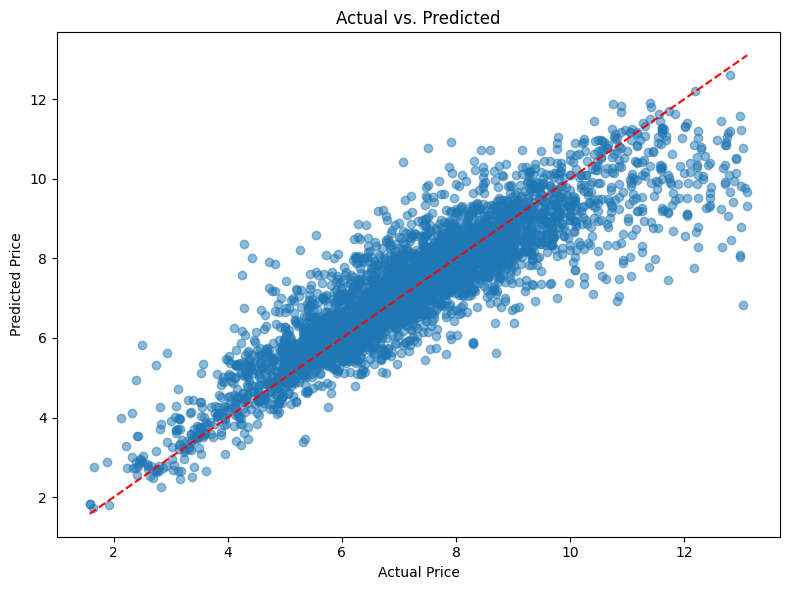

In [9]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs. Predicted")
plt.tight_layout()
plt.show()
plt.close()

#### Feature importance

<Figure size 1000x800 with 0 Axes>

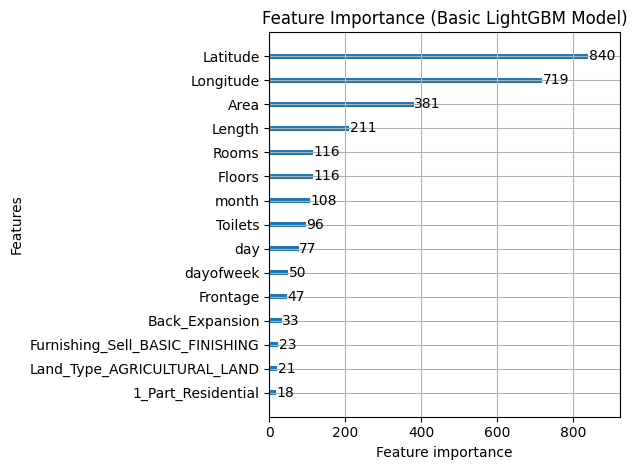

In [10]:
plt.figure(figsize=(10,8))
lgb.plot_importance(basic_model, max_num_features=15)
plt.title("Feature Importance (Basic LightGBM Model)")
plt.tight_layout()
plt.show()
plt.close()

#### Hyperparameter tuning

In [11]:
# param_grid = {
#     'num_leaves': list(range(70, 101, 5)),  # [10, 15, 20, 25, ..., 100]
#     'learning_rate': [round(0.01 + i*0.01, 2) for i in range(10)],  # [0.01, 0.02, ..., 0.3]
#     'n_estimators': list(range(10, 401, 50)),  # [10, 60, 110, ..., 1000]
#     'max_depth': list(range(5, 16)),  # [5, 6, 7, ..., 15]
#     'min_child_samples': list(range(20, 50, 5)),  # [5, 10, 15, ..., 100]
#     'subsample': [round(0.5 + i*0.05, 2) for i in range(11)],  # [0.5, 0.55, ..., 1.0]
#     'colsample_bytree': [round(0.5 + i*0.05, 2) for i in range(11)]  # [0.5, 0.55, ..., 1.0]
# }

# param_grid = {
#     'num_leaves': [31, 51, 71, 91],
#     'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.2, 0.3],
#     'n_estimators': [50, 100, 250, 500, 750, 1000],
#     'max_depth': [5, 7, 9, 11, 13, 15],
#     'min_child_samples': [5, 15, 30, 50, 80, 100],
#     'subsample': [0.5, 0.6, 0.8, 1.0],
#     'colsample_bytree': [0.5, 0.6, 0.8, 1.0]
# }

# param_grid = {
#     'num_leaves': [31, 50, 70],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'n_estimators': [100, 200, 300],
#     'min_child_samples': [20, 30, 50],
#     'subsample': [0.8, 0.9, 1.0],
#     'colsample_bytree': [0.8, 0.9, 1.0]
# }

param_grid = {
    'num_leaves': [78],
    'learning_rate': [0.04],
    'n_estimators': [270],
    'min_child_samples': [24],
    'subsample': [0.8],
    'colsample_bytree': [0.9]
}

lgbm_estimator = lgb.LGBMRegressor(objective='regression', random_state=42)
grid = GridSearchCV(
    lgbm_estimator,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train, y_train)
# Best parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'min_child_samples': 30, 'n_estimators': 300, 'num_leaves': 70, 'subsample': 0.8}
print("Best parameters:", grid.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Best parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.04, 'min_child_samples': 24, 'n_estimators': 270, 'num_leaves': 78, 'subsample': 0.8}


#### Evaluate optimized model

In [12]:
best_model = grid.best_estimator_
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print("\n=== LightGBM Model Evaluation ===")
print(f"Training MSE: {mse_train:.5f}, RMSE: {rmse_train:.5f}, MAE: {mae_train:.5f}, R2: {r2_train:.4f}")
print(f"Test MSE: {mse_test:.5f}, RMSE: {rmse_test:.5f}, MAE: {mae_test:.5f}, R2: {r2_test:.4f}")


=== LightGBM Model Evaluation ===
Training MSE: 0.36537, RMSE: 0.60446, MAE: 0.41562, R2: 0.8925
Test MSE: 0.59901, RMSE: 0.77396, MAE: 0.51879, R2: 0.8273


#### Plot actual vs predicted (optimized)

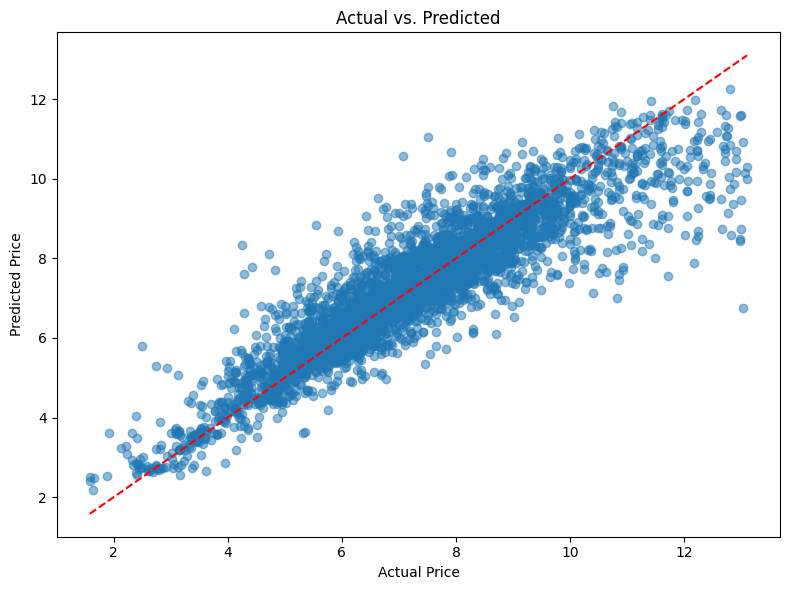

In [13]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs. Predicted")
plt.tight_layout()
plt.show()
plt.close()

#### Error analysis

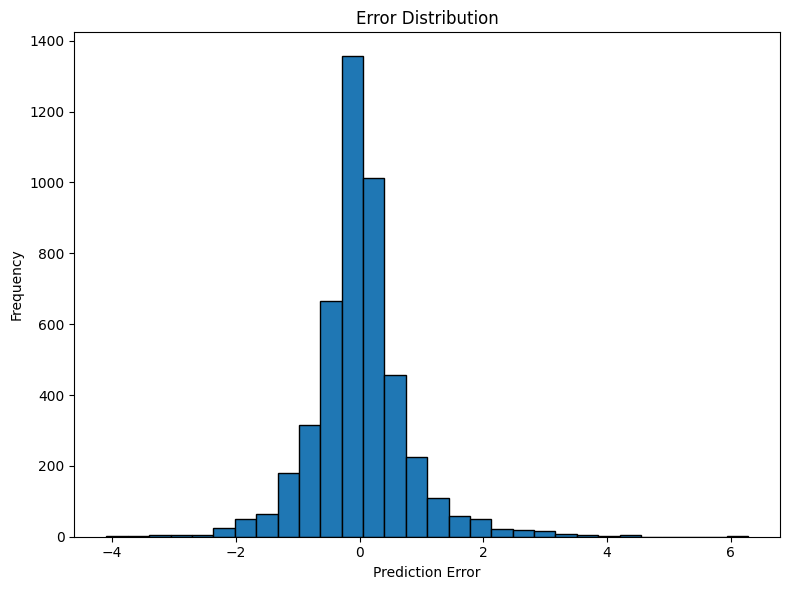

In [14]:
errors = y_test - y_test_pred
plt.figure(figsize=(8,6))
plt.hist(errors, bins=30, edgecolor='k')
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Error Distribution")
plt.tight_layout()
plt.show()
plt.close()

#### Cross-validation

In [15]:
cv_scores = cross_val_score(
    best_model, X_train, y_train,
    cv=5, scoring='neg_mean_squared_error'
)
print("\nCross-val MSE mean: {:.5f}, std: {:.5f}".format(-cv_scores.mean(), cv_scores.std()))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines

Cross-val MSE mean: 0.60513, std: 0.02079


#### Train final model on full dataset

In [16]:
final_model = lgb.LGBMRegressor(**grid.best_params_, objective='regression', random_state=42)
final_model.fit(X, y)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


LGBMRegressor(colsample_bytree=0.9, learning_rate=0.04, min_child_samples=24,
              n_estimators=270, num_leaves=78, objective='regression',
              random_state=42, subsample=0.8)

#### Save models


In [17]:
pipeline = PMMLPipeline([
    ("regressor", final_model)
])

output_dir = '../../Backend/src/main/resources/'
os.makedirs(output_dir, exist_ok=True)

with open('lightgbm_final_model.pmml', 'wb') as f:
    pickle.dump(pipeline, f)

pmml_path = os.path.join(output_dir, 'lightgbm_final_model.pmml')
sklearn2pmml(pipeline, pmml_path)

with open('lightgbm_final_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)

with open(output_dir + 'lightgbm_final_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)

print("Saved final model to lightgbm_final_model.pkl")

Saved final model to lightgbm_final_model.pkl


#### Generate forecast


Generating 90-day forecast...


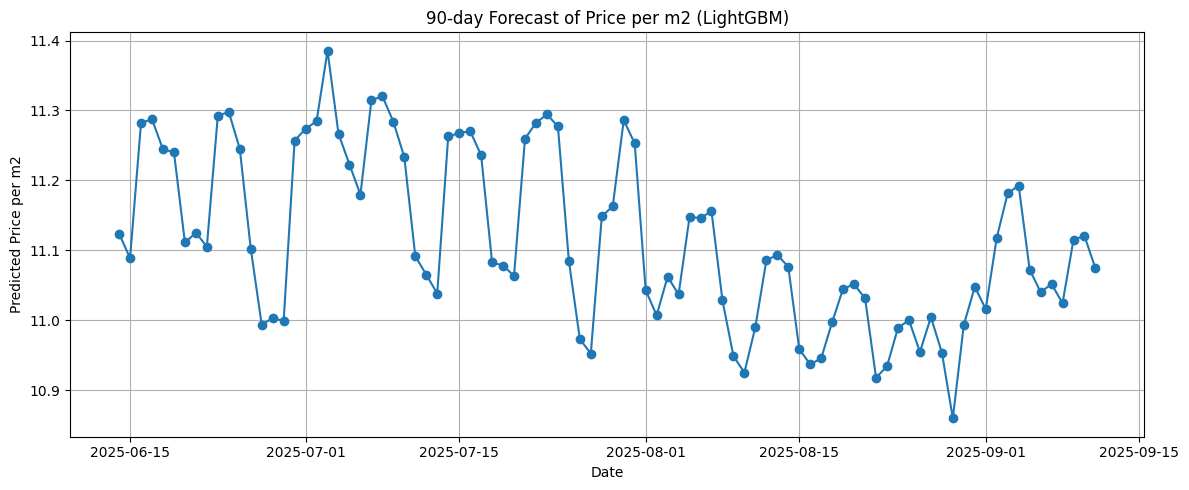

In [18]:
print("\nGenerating 90-day forecast...")
# Get baseline (latest sample)
base = X.iloc[-1].copy()

# Start date for forecasting (today)
start_date = pd.Timestamp.now().normalize()

# Generate forecasts
results = []
for i in range(90):
    date = start_date + timedelta(days=i)
    f = base.copy()
    
    # Update time features
    f['year'] = date.year
    f['month'] = date.month
    f['day'] = date.day
    f['dayofweek'] = date.weekday()
    f['quarter'] = date.quarter
    
    # Predict
    X_pred = f.values.reshape(1, -1)
    pred_price = final_model.predict(X_pred)[0]
    
    results.append({
        'Date': date,
        'LGBM_Predicted_Price_per_m2': pred_price
    })

forecast_df = pd.DataFrame(results)

# Plot forecast
plt.figure(figsize=(12, 5))
plt.plot(forecast_df['Date'], forecast_df['LGBM_Predicted_Price_per_m2'], marker='o')
plt.title('90-day Forecast of Price per m2 (LightGBM)')
plt.xlabel('Date')
plt.ylabel('Predicted Price per m2')
plt.grid(True)
plt.tight_layout()
plt.show()